This notebook is the second part of [RANZCR 1st Place Solution by TF](https://www.kaggle.com/tt195361/ranzcr-1st-place-solution-by-tf-1-make-masks), training of the segmentation model. This notebook is based on [RANZCR 1st Place Soluiton Seg Model (small ver.)](https://www.kaggle.com/haqishen/ranzcr-1st-place-soluiton-seg-model-small-ver).

For the segmentation model, the original notebook uses UnetPlusPlus in [segmentation_models_pytorch](https://github.com/qubvel/segmentation_models.pytorch). At first, I tried to convert it to Keras by using torch.onnx.export() and [onnx2keras](https://github.com/nerox8664/onnx2keras) in this [version](https://www.kaggle.com/tt195361/ranzcr-1st-place-solution-by-tf-2-seg-model?scriptVersionId=57986327). But the training of this model didn't improve accuracy. So, I changed to use Unet in [Segmentation Models](https://github.com/qubvel/segmentation_models).

I selected EfficientNetB5 for the base of Unet. The original notebook uses EfficientNetB1.

For data augmentation, the original notebook uses methods in [Albumentations](https://github.com/albumentations-team/albumentations). I made similar one by Tensorflow.

It took about 4 hours and 30 minutes on TPU to run 1 fold. So some number of sessions are necessary to run a set of folds.

The plots below are sample training history of this model. They are from [Version 10](https://www.kaggle.com/tt195361/ranzcr-1st-place-solution-by-tf-2-seg-model?scriptVersionId=61479593). The accuracy grew up to around 80% gradually. CV result of classification model by using this result is about 0.964 ~ 0.967.

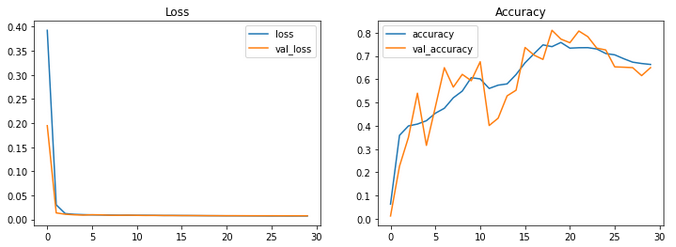

In some trainings, the accuracy became to almost 100% in a few epochs, then kept decreasing. It looks unusual. The plots below are the history of [Version 9](https://www.kaggle.com/tt195361/ranzcr-1st-place-solution-by-tf-2-seg-model?scriptVersionId=61377764). CV result from this result is about 0.948, worse than the above one.

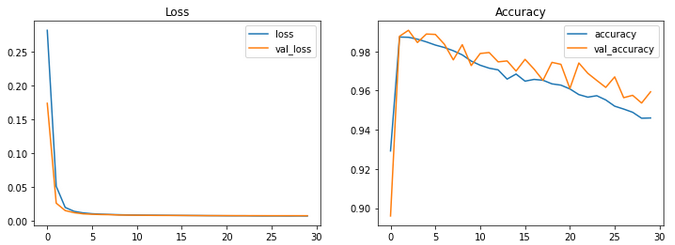


## Install Segmentation Models Locally

In [ ]:
%env SM_FRAMEWORK=tf.keras
!pip install ../input/segmentation-models-keras/Keras_Applications-1.0.8-py3-none-any.whl --quiet
!pip install ../input/segmentation-models-keras/image_classifiers-1.0.0-py3-none-any.whl --quiet
!pip install ../input/segmentation-models-keras/efficientnet-1.0.0-py3-none-any.whl --quiet
!pip install ../input/segmentation-models-keras/segmentation_models-1.0.1-py3-none-any.whl --quiet

print("Segmentation Models installed.")

## Config and Libraries

In [ ]:
DEBUG = True

In [ ]:
# libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import io
import math
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import segmentation_models as sm
from kaggle_datasets import KaggleDatasets

print(tf.__version__)

In [ ]:
enet_type = 'efficientnetb5'
image_size = 1024
batch_size = 16 # original is 4
init_lr = 1e-4
warmup_epo = 1
# If DEBUG == True, only run 3 epochs per fold
cosine_epo = 29 if not DEBUG else 2
n_epochs = warmup_epo + cosine_epo

VID = "V12"
FOLD_I_LIST=[0]

In [ ]:
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

## TPU

[Tensorflow 2.4 for TPUs released](https://www.kaggle.com/product-feedback/216256)

In [ ]:
try: # detect TPUs
    # NEW: in Tensorflow 2.4
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # otherwise detect GPUs
    strategy = tf.distribute.MirroredStrategy() # single-GPU or multi-GPU
    
print(f"Running on {strategy.num_replicas_in_sync} replicas")

In [ ]:
seg_masks = 'ranzcr-segmentation-masks'
GCS_DS_PATH = KaggleDatasets().get_gcs_path(seg_masks)

GCS_DS_PATH

## Define Dataset

In [ ]:
def decode_image(image_bytes):
    image = tf.image.decode_jpeg(image_bytes, channels=3)
    return image

def decode_mask(mask_bytes):
    mask = tf.io.decode_png(mask_bytes, channels=3)
    return mask

def read_tfrecord(example):
    TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'fold': tf.io.FixedLenFeature([], tf.int64),
    }
    
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    mask = decode_mask(example['mask'])
    fold = example['fold']

    image = tf.reshape(image, (image_size, image_size, 3))
    mask = tf.reshape(mask, (image_size, image_size, 3))
    return image, mask, fold

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=None)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=None)
    return dataset

In [ ]:
tfrec_file_names = tf.io.gfile.glob(GCS_DS_PATH + '/*.tfrec')
tfrec_file_names = \
    [ tfrec_file_names[0] ] if DEBUG else tfrec_file_names
raw_ds = load_dataset(tfrec_file_names)

print(raw_ds)

Count the number of data in each folds for train and validation.

In [ ]:
folds_list = []
for _, _, fold_batch in raw_ds.batch(256):
    print('.', end='', flush=True)
    folds_list.append(fold_batch)

folds = np.concatenate(folds_list)
fold, counts = np.unique(folds, return_counts=True)
fold_count_dict = dict(zip(fold, counts))

fold_count_dict

In [ ]:
def fold_train_count(fold_i):
    counts = [ 
        count for fold, count in fold_count_dict.items() \
        if fold != fold_i ]
    return sum(counts)

def fold_val_count(fold_i):
    return fold_count_dict[fold_i]

## Augumentations

### Utilities

In [ ]:
def scale_image_mask(image, mask):
    image = tf.cast(image, dtype=tf.float32) / 255.0
    # Value range of mask is 0..1, so type cast only.
    mask = tf.cast(mask, dtype=tf.float32)
    return image, mask

In [ ]:
def check_aug(aug_fun, with_mask):
    image, mask, _ = next(iter(raw_ds.take(1)))
    image, mask = scale_image_mask(image, mask)
    
    plt.figure(figsize=(12, 4))
    rows = 2
    cols = 5
    aug_masks = []
    for p in range(rows*cols):
        aug_image, aug_mask = aug_fun(image, mask)
        aug_masks.append(aug_mask)
        
        plt.subplot(rows, cols, p+1)
        plt.imshow(aug_image)
        plt.axis("off")
    plt.tight_layout()
    plt.show()        
    
    if with_mask:
        plt.figure(figsize=(12, 4))
        for p, aug_mask in enumerate(aug_masks):
            plt.subplot(rows, cols, p+1)
            plt.imshow(aug_mask)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

In [ ]:
def random_float(minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(
        [], minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

def choice(p, image1, mask1, image2, mask2):
    rnd = random_float()
    image = tf.where(rnd <= p, image1, image2)
    mask = tf.where(rnd <= p, mask1, mask2)
    return image, mask

In [ ]:
def mirror_boundary(v, max_v):
    # v % (max_v*2.0-2.0) ==> v % (512*2-2) ==> [0..1022]
    # [0..1022] - (max_v-1.0) ==> [0..1022] - 511 ==> [-511..511]
    # -1.0 * abs([-511..511]) ==> [-511..0]
    # [-511..0] + max_v - 1.0 ==> [-511..0] + 511 ==> [0..511]
    mirror_v = -1.0 * tf.math.abs(
        v % (max_v*2.0-2.0) - (max_v-1.0)) + max_v-1.0
    return mirror_v

def clip_boundary(v, max_v):
    clip_v = tf.clip_by_value(v, 0.0, max_v-1.0)
    return clip_v

def interpolate_bilinear(image, map_x, map_y):
    def _gather(image, map_x, map_y):
        map_stack = tf.stack([map_x, map_y]) # [ 2, height, width ]
        map_indices = tf.transpose(
            map_stack, perm=[1, 2, 0])       # [ height, width, 2 ]
        map_indices = tf.cast(map_indices, dtype=tf.int32)
        gather_image = tf.gather_nd(image, map_indices)
        return gather_image
    
    ll = _gather(image, tf.math.floor(map_x), tf.math.floor(map_y))
    lr = _gather(image, tf.math.ceil(map_x), tf.math.floor(map_y))
    ul = _gather(image, tf.math.floor(map_x), tf.math.ceil(map_y))
    ur = _gather(image, tf.math.ceil(map_x), tf.math.ceil(map_y))
    
    fraction_x = tf.expand_dims(map_x % 1.0, axis=-1) # [h, w, 1]
    int_l = (lr - ll) * fraction_x + ll
    int_u = (ur - ul) * fraction_x + ul
    
    fraction_y = tf.expand_dims(map_y % 1.0, axis=-1) # [h, w, 1]
    interpolate_image = (int_u - int_l) * fraction_y + int_l
    return interpolate_image

def remap(image, height, width, map_x, map_y, mode):
    assert \
        mode in ('mirror', 'constant'), \
        "mode is neither 'mirror' nor 'constant'"

    height_f = tf.cast(height, dtype=tf.float32)
    width_f = tf.cast(width, dtype=tf.float32)
    map_x = tf.reshape(map_x, shape=[height, width])
    map_y = tf.reshape(map_y, shape=[height, width])
    if mode == 'mirror':
        b_map_x = mirror_boundary(map_x, width_f)
        b_map_y = mirror_boundary(map_y, height_f)
    else:
        b_map_x = clip_boundary(map_x, width_f)
        b_map_y = clip_boundary(map_y, height_f)
        
    image_remap = interpolate_bilinear(image, b_map_x, b_map_y)
    
    if mode == 'constant':
        map_stack = tf.stack([map_x, map_y])
        map_indices = tf.transpose(map_stack, perm=[1, 2, 0])
        x_ge_0 = (0.0 <= map_indices[ : , : , 0])    # [h, w]
        x_lt_w = (map_indices[ : , : , 0] < width_f)
        y_ge_0 = (0.0 <= map_indices[ : , : , 1])
        y_lt_h = (map_indices[ : , : , 1] < height_f)
        inside_boundary = tf.math.reduce_all(
            tf.stack([x_ge_0, x_lt_w, y_ge_0, y_lt_h]), axis=0) # [h, w]
        inside_boundary = inside_boundary[ : , : , tf.newaxis]  # [h, w, 1]
        image_remap = tf.where(inside_boundary, image_remap, 0.0)

    return image_remap

### HorizontalFlip

In [ ]:
def HorizontalFlip(p):
    def _do_horizontal_flip(image, mask):
        aug_image = tf.image.flip_left_right(image)
        aug_mask = tf.image.flip_left_right(mask)
        return choice(p, aug_image, aug_mask, image, mask)
    return _do_horizontal_flip

In [ ]:
horizontal_flip = HorizontalFlip(p=0.5)
check_aug(horizontal_flip, with_mask=True)

### RandomBrightness

In [ ]:
def RandomBrightness(max_delta, p):
    def _do_random_brightness(image, mask):
        aug_image = tf.image.random_brightness(image, max_delta)
        return choice(p, aug_image, mask, image, mask)
    return _do_random_brightness

In [ ]:
random_brightness = RandomBrightness(max_delta=0.2, p=0.75)
check_aug(random_brightness, with_mask=False)

### ShiftScaleRotate

In [ ]:
def affine_transform(height, width, tx, ty, z, theta):
    cx = (width - 1.0) * 0.5
    cy = (height - 1.0) * 0.5
    
    center_shift_mat = tf.convert_to_tensor([
        [1.0, 0.0, -cx],
        [0.0, 1.0, -cy],
        [0.0, 0.0, 1.0]], dtype=tf.float32)
    trans_mat = center_shift_mat
    
    rot_rad = -2.0 * math.pi * theta / 360.0
    roration_mat = tf.convert_to_tensor([
        [tf.math.cos(rot_rad), tf.math.sin(rot_rad), 0.0],
        [-tf.math.sin(rot_rad), tf.math.cos(rot_rad), 0.0],
        [0.0, 0.0, 1.0]], dtype=tf.float32)
    trans_mat = tf.linalg.matmul(roration_mat, trans_mat)
    
    shift_mat = tf.convert_to_tensor([
        [1.0, 0.0, cx - tx],
        [0.0, 1.0, cy - ty],
        [0.0, 0.0, 1.0]], dtype=tf.float32)
    trans_mat = tf.linalg.matmul(shift_mat, trans_mat)

    zoom_mat = tf.convert_to_tensor([
        [1.0 / z, 0.0, 0.0],
        [0.0, 1.0 / z, 0.0],
        [0.0, 0.0, 1.0]], dtype=tf.float32)
    trans_mat = tf.linalg.matmul(zoom_mat, trans_mat)
    
    h_rng = tf.range(height, dtype=tf.float32)
    w_rng = tf.range(width, dtype=tf.float32)
    y, x = tf.meshgrid(h_rng, w_rng)
    x = tf.reshape(x, [-1])
    y = tf.reshape(y, [-1])
    ones = tf.ones_like(x)
    coord_mat = tf.stack([x, y, ones])
    
    res_mat = tf.linalg.matmul(trans_mat, coord_mat)
    map_x = res_mat[0]
    map_y = res_mat[1]
    return map_x, map_y

In [ ]:
def ShiftScaleRotate(
        shift_limit, scale_limit, rotate_limit, p):
    def _do_shift_scale_rotate(image, mask):
        image_shape = tf.shape(image)
        height_i = image_shape[0]
        width_i = image_shape[1]
        height_f = tf.cast(height_i, dtype=tf.float32)
        width_f = tf.cast(width_i, dtype=tf.float32)
        tx = width_f * random_float(-shift_limit, shift_limit)
        ty = height_f * random_float(-shift_limit, shift_limit)
        z = random_float(1.0 - scale_limit, 1.0 + scale_limit)
        theta = random_float(-rotate_limit, rotate_limit)

        map_x, map_y = affine_transform(
            height_f, width_f, tx, ty, z, theta)
        aug_image = remap(
            image, height_i, width_i, map_x, map_y, mode='constant')
        aug_mask = remap(
            mask, height_i, width_i, map_x, map_y, mode='constant')
        return choice(p, aug_image, aug_mask, image, mask)
    return _do_shift_scale_rotate

In [ ]:
shift_scale_rotate = ShiftScaleRotate(
    shift_limit=0.2, scale_limit=0.3, rotate_limit=30, p=0.75)
check_aug(shift_scale_rotate, with_mask=True)

### Cutout

In [ ]:
def randints(shape, minval, maxval):
    # maxval+1 to include maxval for the result.
    # generated range is [minval, maxval) (maxval is not included)
    return tf.random.uniform(
        shape=shape, minval=minval, maxval=maxval+1, dtype=tf.int32)

def make_range_masks(size, starts, ends):
    indice = tf.range(size, dtype=tf.int32)
    start_masks = (
        starts[ : , tf.newaxis] <= indice[  tf.newaxis, : ])
    end_masks = (
        indice[ tf.newaxis, : ] <= ends[ : , tf.newaxis])
    range_masks = start_masks & end_masks
    return range_masks

def make_region_mask(tops, lefts, bottoms, rights):
    row_masks = make_range_masks(image_size, tops, bottoms)
    col_masks = make_range_masks(image_size, lefts, rights)
    region_masks = \
        row_masks[ : , : , tf.newaxis ] & \
        col_masks[ : , tf.newaxis, : ]
    region_mask = tf.math.reduce_any(region_masks, axis=0)
    region_mask = region_mask[ : , : , tf.newaxis]
    return region_mask

def Cutout(num_cuts, mask_factor, p):
    def _do_cutout(image, mask):
        image_shape = tf.shape(image)
        height_i = image_shape[0]
        width_i = image_shape[1]
        height_f = tf.cast(height_i, dtype=tf.float32)
        width_f = tf.cast(width_i, dtype=tf.float32)
        cut_h = tf.cast(height_f * mask_factor, dtype=tf.int32)
        cut_w = tf.cast(width_f * mask_factor, dtype=tf.int32)

        y_centers = randints([num_cuts], 0, image_size - 1)
        x_centers = randints([num_cuts], 0, image_size - 1)
        tops = tf.math.maximum(y_centers - cut_h//2, 0)
        lefts = tf.math.maximum(x_centers - cut_w//2, 0)
        bottoms = tf.math.minimum(tops + cut_h, height_i - 1)
        rights = tf.math.minimum(lefts + cut_w, width_i - 1)

        cut_region = make_region_mask(tops, lefts, bottoms, rights)
        mask_value = tf.constant(0.0, dtype=tf.float32)
        aug_image = tf.where(cut_region, mask_value, image)
        return choice(p, aug_image, mask, image, mask)
    return _do_cutout

In [ ]:
cut_out = Cutout(num_cuts=1, mask_factor=0.3, p=0.75)
check_aug(cut_out, with_mask=False)

In [ ]:
def do_augment(image, mask):
    image, mask = horizontal_flip(image, mask)
    image, mask = random_brightness(image, mask)
    image, mask = shift_scale_rotate(image, mask)
    image, mask = cut_out(image, mask)
    return image, mask

## Dataset 2

In [ ]:
def select_train(ds, fold):
    ds = ds.filter(lambda im, ms, f: f != fold)
    return ds
    
def select_val(ds, fold):
    ds = ds.filter(lambda im, ms, f: f == fold)
    return ds

In [ ]:
def drop_fold(image, mask ,fold):
    return image, mask

# Actual mask is 2 channel, the last one is added for encoding as PNG.
def drop_mask_channel(image, mask):
    mask = mask[ : , : , :-1 ]
    return image, mask

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def build_dataset(
        dset, augment=True, repeat=True, shuffle=1024):
    dset = dset.map(drop_fold, num_parallel_calls=AUTOTUNE)
    dset = dset.repeat() if repeat else dset
    dset = dset.map(scale_image_mask, num_parallel_calls=AUTOTUNE)
    dset = dset.map(
        do_augment, num_parallel_calls=AUTOTUNE) if augment else dset
    dset = dset.map(drop_mask_channel, num_parallel_calls=AUTOTUNE)
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(batch_size)
    dset = dset.prefetch(AUTOTUNE)
    return dset

In [ ]:
def make_datasets(fold_i):
    train_ds = select_train(raw_ds, fold_i)
    train_ds = build_dataset(
        train_ds, augment=True, repeat=True, shuffle=1024)

    val_ds = select_val(raw_ds, fold_i)
    val_ds = build_dataset(
        val_ds, augment=False, repeat=False, shuffle=None)

    train_steps = fold_train_count(fold_i) // batch_size
    val_steps = fold_val_count(fold_i) // batch_size

    return train_ds, val_ds, train_steps, val_steps

## Visualization

In [ ]:
train_ds, val_ds, train_steps, val_steps = make_datasets(0)

In [ ]:
from pylab import rcParams

def visualize_images(ds):
    rcParams['figure.figsize'] = 20,10

    f, axarr = plt.subplots(1,5)
    masks = []
    ds_iter = iter(ds.unbatch())
    for p in range(5):
        img, mask = next(ds_iter)
        axarr[p].imshow(img)
        masks.append(mask)

    f, axarr = plt.subplots(1,5)
    for p in range(5):
        axarr[p].imshow(masks[p][ : , : , 0])

    f, axarr = plt.subplots(1,5)
    for p in range(5):
        axarr[p].imshow(masks[p][ : , : , 1])

In [ ]:
visualize_images(train_ds)

In [ ]:
visualize_images(val_ds)

## Model

In [ ]:
def make_model():
    with strategy.scope(): 
        unet = sm.Unet(
            enet_type, encoder_weights='imagenet',
            classes=2, activation='sigmoid')
        
        inputs = tf.keras.Input(
            shape=(image_size, image_size, 3), name="inputs")
        outputs = unet(inputs)
        model = tf.keras.Model(
            inputs=inputs, outputs=outputs, name="seg_model")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy'],
        # overheads and allows the XLA compiler to unroll the loop on TPU
        # and optimize hardware utilization.
        steps_per_execution=8)
    model.summary()

    return model

In [ ]:
model = make_model()

In [ ]:
from matplotlib import pyplot as plt

LR_START = init_lr
LR_MAX = 1e-3
LR_MIN = 1e-5
LR_RAMPUP_EPOCHS = warmup_epo
LR_SUSTAIN_EPOCHS = 0
EPOCHS = n_epochs

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))

In [ ]:
cb_monitor = 'val_accuracy'

class RestoreBestWeights(tf.keras.callbacks.Callback):
    def __init__(self):
        super(RestoreBestWeights, self).__init__()
        self.best_monitor = -np.Inf
        self.best_weights = None
        self.best_epoch = None
        
    def on_epoch_end(self, epoch, logs=None):
        current_monitor = logs.get(cb_monitor)
        if current_monitor > self.best_monitor:
            self.best_monitor = current_monitor
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch
            
    def on_train_end(self, logs=None):
        print("Restoring best weights on epoch {0}, {1} was {2:.5f}".format(
            self.best_epoch + 1, cb_monitor, self.best_monitor))
        self.model.set_weights(self.best_weights)

In [ ]:
def make_callbacks(fold_i):
    best_model_file_name = "seg_model_{0}_{1}.hdf5".format(VID, fold_i)
    cb_mode = 'max'
    cb_min_delta = 1e-4
    cb_verbose = 1

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        best_model_file_name, save_best_only=True,
        save_weights_only=False, monitor=cb_monitor, mode=cb_mode,
        verbose=cb_verbose)
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
    restore_best_weights = RestoreBestWeights()
    
    return checkpoint, lr_callback, restore_best_weights

In [ ]:
def fit_one_fold(fold_i):
    train_dataset, val_dataset, train_steps, val_steps = make_datasets(fold_i)
    checkpoint, lr_callback, restore_best_weights = make_callbacks(fold_i)

    history = model.fit(
        train_dataset, 
        epochs=EPOCHS,
        verbose=1,
        callbacks=[checkpoint, lr_callback, restore_best_weights],
        steps_per_epoch=train_steps,
        validation_data=val_dataset,
        validation_steps=val_steps)
    return history

In [ ]:
def plot_history(history, title, labels, subplot):
    plt.subplot(*subplot)
    plt.title(title)
    for label in labels:
        plt.plot(history.history[label], label=label)
    plt.legend()

In [ ]:
def plot_fit_result(history):
    plt.figure(figsize=(12, 4))
    plot_history(history, "Loss", ['loss', 'val_loss'], (1, 2, 1))
    plot_history(history, "Accuracy", ['accuracy', 'val_accuracy'], (1, 2, 2))
    plt.show()

In [ ]:
for fold_i in FOLD_I_LIST:
    print("####################")
    print("# Fold {0}".format(fold_i))
    history = fit_one_fold(fold_i)
    plot_fit_result(history)